In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, deactivate_crossing_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
importlib.reload(deactivate_crossing_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, get_max_distance_to_target_surface, get_average_distance_to_target_surface)
from deactivate_crossing_helper import get_segment_index_from_joints
import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
rod_length = 0.5
width = rod_length / 50 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('amethyst_1', thickness, width, weaving_dir)
# This is just to get a random surface

0.05 0.0034999999999999996


In [4]:
io.SUBDIVISION_RESOLUTION = 50

In [5]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 5
sw = 10
drw = 0.1
dsw = 0.01

### Initialization

In [6]:
import pickle 
import gzip
# pickle.dump(curved_linkage, gzip.open('{}_{}.pkl.gz'.format(io.MODEL_NAME, time.time()), 'w'))

In [7]:
# curved_linkage = pickle.load(gzip.open('regular_4_7_1607520544.236602.pkl.gz', 'r'))
# curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
# curved_linkage_view.show()

In [8]:
# np.save('{}_design_parameters.npy'.format(io.MODEL_NAME), curved_linkage.getDesignParameters())

In [9]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = False, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.weaving)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions()
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

### Stage 1 and manually untwist twisted ribbon

In [10]:
E0 = curved_linkage.designParameterSolve_energy()
l0 = curved_linkage.totalRestLength()
curved_linkage.joint(4).set_terminalEdgeNormalSign(10, 1)
curved_linkage.joint(0).set_terminalEdgeNormalSign(10, 1)
curved_linkage.joint(15).set_terminalEdgeNormalSign(14, -1)
curved_linkage.joint(14).set_terminalEdgeNormalSign(14, 1)
iterateData, dpo = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view, E0 = E0, l0 = l0, niter = 400)
curved_linkage.joint(15).set_terminalEdgeNormalSign(14, 1)
iterateData, dpo = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view, E0 = E0, l0 = l0, niter = 400)

AttributeError: 'elastic_rods.Joint' object has no attribute 'set_terminalEdgeNormalSign'

In [11]:
bottomColor =[79/255., 158/255., 246/255.]
topColor =[0.5, 0.5, 0.5]
heights = curved_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [12]:
double_view = linkage_vis.LinkageViewer(curved_linkage)
double_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [13]:
double_view.update(scalarField=colors)

In [14]:
curved_linkage_view.setCameraParams(((4.139347366530763, -3.927678946178955, 0.7924706632167623),
 (-0.038125872037145875, 0.15887387844372028, 0.9865624707182293),
 (0.0, 0.0, 0.0)))

In [15]:
# curved_linkage.setDesignParameters(np.load('{}_design_parameters.npy'.format(io.MODEL_NAME)))

In [16]:
curved_linkage.attraction_weight = 0

In [17]:
# vf = show_selected_joints(curved_linkage, [15, 14], flip = False)
# curved_linkage_view.update(vectorField = vf, scalarField = colors)

In [18]:
# curved_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, [thickness, width], stiffAxis=elastic_rods.StiffAxis.D1))

In [19]:
def eqm_callback(prob, i):
    curved_linkage_view.update(scalarField=colors)

In [20]:
driver=curved_linkage.centralJoint()
jdo = curved_linkage.dofOffsetForJoint(driver)
fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
with so(): elastic_rods.compute_equilibrium(curved_linkage, fixedVars=fixedVars, callback = eqm_callback, options = OPTS)

In [21]:
# curved_save_tgt_joint_pos = curved_linkage.jointPositions()

In [22]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw)

In [23]:
optimizer.scaleJointWeights(1, 1, [])

In [24]:
optimizer.set_holdClosestPointsFixed(True)

In [25]:
optimizer.beta = 1e7

In [ ]:
optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, no_surface = True, maxIter = 100)

rl_regularization_weight 5.0
smoothing_weight 10.0


Min Width  0.05
Scale:  100.0
num seg per rod 12
num seg per rod 12
num seg per rod 6
num seg per rod 6
num seg per rod 12
num seg per rod 12
num seg per rod 6
num seg per rod 6
num seg per rod 6
num seg per rod 6
0.2


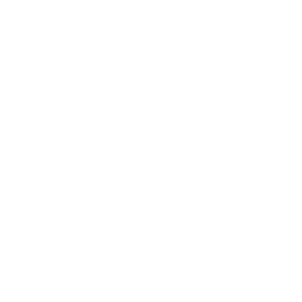

In [26]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False)
os.chdir(save_path)

In [39]:
export_linkage_geometry_to_obj(curved_linkage, '{}_contact_opt.obj'.format(io.MODEL_NAME))

## Contact Optimization

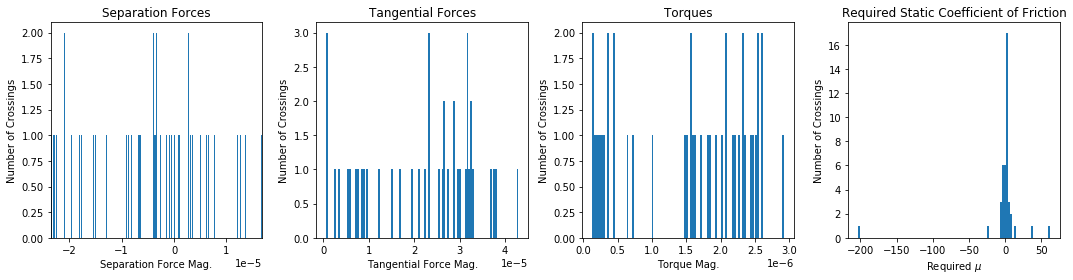

In [27]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [28]:
def get_opposite_joint_type(curr_type):
    if curr_type == curved_linkage.joint(0).Type.A_OVER_B:
        return curved_linkage.joint(0).Type.B_OVER_A
    return curved_linkage.joint(0).Type.A_OVER_B
import structural_analysis

In [29]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [38  2 35 32 15 16 28 25 12 22 21 13 19  6 41]
0	0.00198946	0.619769	0.619769	0.25	1
1	0.00139853	0.96456	0.96456	1	1
2	0.000547985	0.228685	0.228685	1	1
3	0.000354173	0.0655696	0.0655696	1	1
4	0.000257305	0.0320419	0.0320419	1	1
5	0.000196716	0.0190062	0.0190062	1	1
6	0.000155673	0.0126201	0.0126201	1	1
7	0.000127186	0.00925882	0.00925882	1	1
8	0.000107328	0.0070719	0.0070719	1	1
9	9.35713e-05	0.00494193	0.00494193	1	1
10	8.42263e-05	0.00328038	0.00328038	1	1
11	7.80818e-05	0.00204777	0.00204777	1	1
12	7.41861e-05	0.00118091	0.00118091	1	1
13	7.18131e-05	0.000647113	0.000647113	1	1
14	7.04008e-05	0.000361791	0.000361791	1	1
15	6.9552e-05	0.000228402	0.000228402	1	1
16	6.90264e-05	0.000165257	0.000165257	1	1
17	6.86883e-05	0.000114566	0.000114566	1	1
18	6.84816e-05	0.000117186	0.000117186	1	1
19	6.83685e-05	0.000118113	0.000118113	1	1
20	6.83067e-05	9.88952e-05	9.88952e-05	1	1
21	6.82683e-05	6.374e-05	6.374e-05	1	1
22	6.82425e-05	4.59641e-05	4.59641e-05	1	1
23	6.822

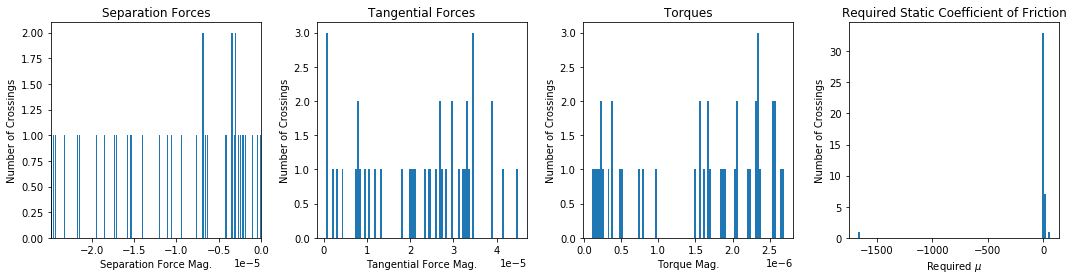

In [30]:
second_structure_view = get_structure_analysis_view(curved_linkage)
second_structure_view.show()

In [31]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [40]
0	0.000342827	0.219982	0.219982	0.0625	1
1	0.000317247	0.300223	0.300223	1	1
2	0.000269646	1.78549	1.78549	1	1
3	0.000117913	0.35982	0.35982	1	1
4	9.80277e-05	0.0214922	0.0214922	1	1
5	9.27493e-05	0.00782052	0.00782052	1	1
6	8.81046e-05	0.00614681	0.00614681	1	1
7	8.38511e-05	0.00491468	0.00491468	1	1
8	8.011e-05	0.00382015	0.00382015	1	1
9	7.69553e-05	0.00317724	0.00317724	1	1
10	7.44059e-05	0.00277645	0.00277645	1	1
11	7.24602e-05	0.00221079	0.00221079	1	1
12	7.10864e-05	0.00157607	0.00157607	1	1
13	7.01805e-05	0.00100822	0.00100822	1	1
14	6.95901e-05	0.000573356	0.000573356	1	1
15	6.91839e-05	0.000342224	0.000342224	1	1
16	6.8886e-05	0.000242454	0.000242454	1	1
17	6.8662e-05	0.000179775	0.000179775	1	1
18	6.84977e-05	0.000131647	0.000131647	1	1
19	6.83819e-05	0.000130265	0.000130265	1	1
20	6.83024e-05	0.000127273	0.000127273	1	1
21	6.82514e-05	0.000169862	0.000169862	1	1
22	6.82218e-05	0.000210085	0.000210085	1	1
23	6.82059e-05	0.000222793	0.000222793	1	1
24

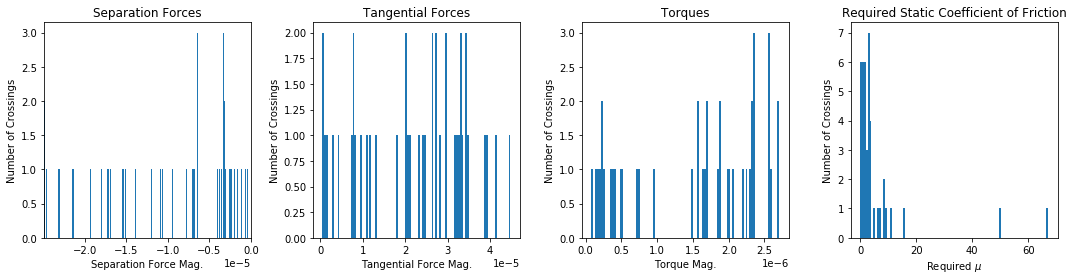

In [32]:
third_structure_view = get_structure_analysis_view(curved_linkage)
third_structure_view.show()

In [38]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

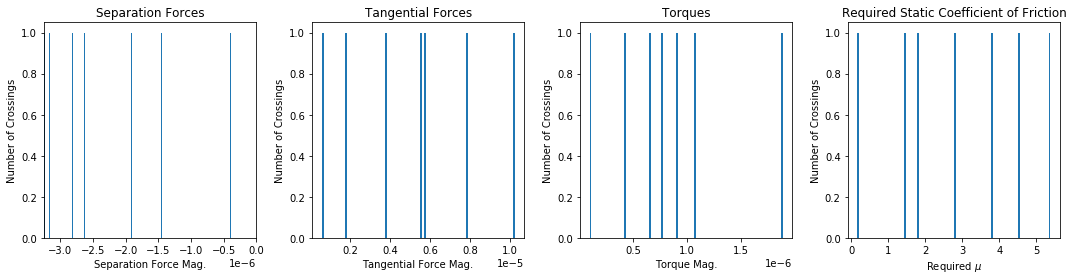

In [39]:
fourth_structure_view = get_structure_analysis_view(curved_linkage)
fourth_structure_view.show()

Min Width  0.05
Scale:  100.0
num seg per rod 12
num seg per rod 12
num seg per rod 6
num seg per rod 6
num seg per rod 12
num seg per rod 12
num seg per rod 6
num seg per rod 6
num seg per rod 6
num seg per rod 6
0.2


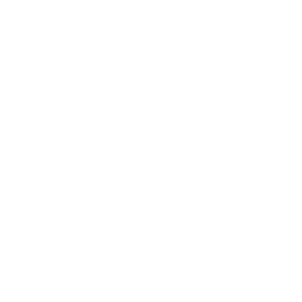

In [33]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME + '_contact_opt', io.RIBBON_NAME + '_contact_opt', False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False)
os.chdir(save_path)